In [1]:
import torch
n_tokens = 12

memory = torch.randint(0, n_tokens, (n_tokens, n_tokens))

memory

tensor([[ 8,  1,  4,  5,  5, 11,  1,  4, 11,  7,  6,  3],
        [ 6,  2,  2,  8,  8,  1,  8,  4, 10, 10,  6, 11],
        [ 8,  4,  8,  6,  3,  4,  9, 11, 10,  3,  7,  4],
        [ 9,  1, 11,  6,  9,  9,  3, 11,  0,  3,  9,  6],
        [11,  1,  8,  6,  3,  9,  1,  6,  5,  6,  2,  3],
        [ 5,  9,  3,  4, 11,  4, 11, 11,  9,  0,  6,  4],
        [10,  7,  9, 11,  6,  3,  1,  7,  6,  3,  8,  8],
        [11,  8, 10,  5,  4,  4,  4,  1, 11,  4,  5,  6],
        [ 1,  6,  3,  0,  4,  8,  8,  6,  9,  0,  8,  8],
        [ 0,  1,  4,  5,  0,  1,  8,  1,  2,  7,  4,  7],
        [ 7,  3,  0,  0,  4, 11, 10, 11,  3, 10,  0, 10],
        [ 0,  7, 11,  6,  9, 11,  1,  0,  3, 11,  2, 11]])

In [2]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, dim_feedforward, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.dim_feedforward = dim_feedforward

        self.self_attn = nn.MultiheadAttention(d_model, n_head, batch_first=True, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, tgt, skip_feedforward=False, skip_self_attn=False, linear_mask=None, history=None):
        hist = {}
        mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(self.device)
        if not skip_self_attn:
            tgt2 = hist['self_attn_non_residual'] = self.self_attn(tgt, tgt, tgt, attn_mask=mask)[0]
            tgt = hist['self_attn'] = tgt + tgt2
        tgt = hist['norm1'] = self.norm1(tgt)
        if self.dim_feedforward > 0 and not skip_feedforward:
            tgt2 = hist['linear1'] = nn.functional.relu(self.linear1(tgt))
            tgt2 = hist['linear1_dropout'] = self.dropout(tgt2)
            if linear_mask is not None:
                tgt2 = tgt2 * linear_mask
            tgt2 = hist['linear2_non_residual'] = self.linear2(tgt2)
            tgt = hist['linear2'] = tgt + tgt2
        tgt = hist['norm2'] = self.norm2(tgt)
        return tgt if history is None else hist[history]

class ToyTransformer(nn.Module):
    def __init__(self, n_layers, d_model, n_head, hidden_size, n_tokens, max_len, dropout=0.0):
        super().__init__()
        self.n_layers = n_layers
        self.d_model = d_model
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.tokens = list(range(n_tokens))
        self.max_len = max_len

        self.embed = nn.Embedding(n_tokens, embedding_dim=d_model)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, n_head=n_head, dim_feedforward=hidden_size)
            for _ in range(n_layers)
        ])
        self.unembed = nn.Linear(d_model, n_tokens)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, skip_feedforward=False, skip_self_attn=False, return_before_embedding=False, linear_mask=None, history=None):
        tgt = self.embed(x)
        for layer in self.layers:
            tgt = layer(tgt, skip_feedforward=skip_feedforward, skip_self_attn=skip_self_attn, linear_mask=linear_mask, history=history)
            if history is not None:
                return tgt
        if return_before_embedding:
            return tgt
        x = self.unembed(tgt)
        return x

    def train(self, lr=1e-3, batch_size=128, n_epochs=1000):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for _ in tqdm(range(n_epochs)):
            batch = self.generate_data(batch_size)
            optimizer.zero_grad()
            output = self(batch)
            loss = criterion(output[:, :-1].reshape(-1, len(self.tokens)), batch[:, 1:].reshape(-1))

            loss.backward()
            optimizer.step()

        print('loss: ', loss.item())

    def generate_data(self, batch_size):
        random_indices = torch.randint(0, n_tokens, (batch_size, 2))  # [batch_size, 2]
        next_tokens = memory[random_indices[:, 0], random_indices[:, 1]].unsqueeze(1)  # [batch_size, 1]
        tensor = torch.cat([random_indices, next_tokens], dim=1)
        return tensor.to(self.device)



In [466]:
hidden_size = 4
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = ToyTransformer(n_layers=1, d_model=8, n_head=4, hidden_size=hidden_size, n_tokens=n_tokens, max_len=3, dropout=0.0).to(device)
model.train(lr=1e-2, n_epochs=10000, batch_size=144 * 2)
samples = 1000
data = model.generate_data(samples)
output = (model(data[:,:-1])[:,-1,:].argmax(dim=-1))
print('Accuracy: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_feedforward=True)[:,-1,:].argmax(dim=-1))
print('Accuracy without feedforward: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_feedforward=True, skip_self_attn=True)[:,-1,:].argmax(dim=-1))
print('Accuracy without both: ', output.eq(data[:,-1]).sum().item() / samples)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:41<00:00, 98.36it/s]

loss:  1.3832650184631348
Accuracy:  0.927
Accuracy without feedforward:  0.273
Accuracy without both:  0.104


In [467]:
data = model.generate_data(1)
print(data)
print(model(data[:,:-1])[:,-1,:].argmax(dim=-1))

tensor([[3, 8, 0]])
tensor([0])


In [468]:
import matplotlib.pyplot as plt

def plot(model_output):
    fig, ax = plt.subplots(figsize=(5, 5))
    accuracy_matrix = model_output.eq(memory).float()
    im = ax.imshow(accuracy_matrix, cmap='RdBu')
    for i in range(n_tokens):
        for j in range(n_tokens):
            t = str(memory[i, j].item()) if accuracy_matrix[i, j].item() == 1.0 else f'{model_output[i, j].item()} ({memory[i, j].item()})'
            text = ax.text(j, i, t,
                           ha="center", va="center", color="w")
    ax.xaxis.tick_top()
    plt.xticks(range(n_tokens), range(n_tokens))
    plt.yticks(range(n_tokens), range(n_tokens))
    fig.tight_layout()
    plt.show()

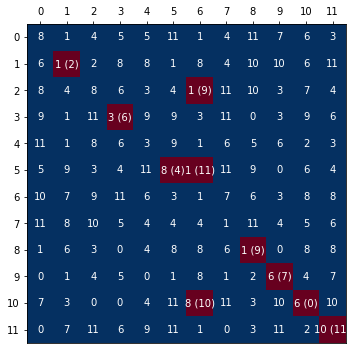

In [469]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
plot(output)

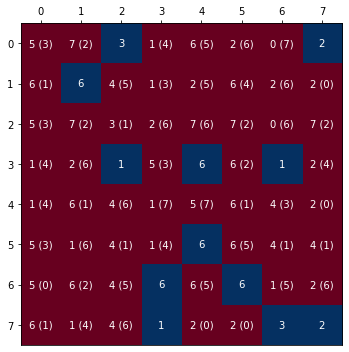

In [12]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, skip_feedforward=True)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
plot(output)

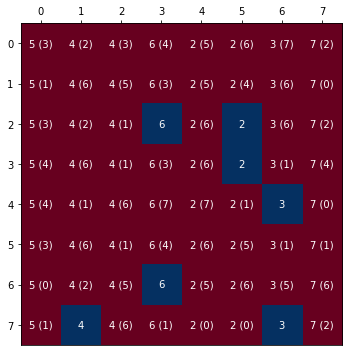

In [13]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, skip_feedforward=True, skip_self_attn=True)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
plot(output)

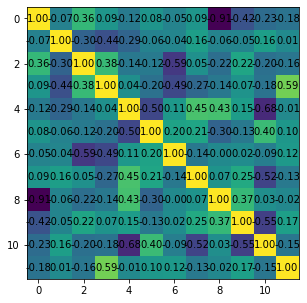

In [6]:
# Embedding cosine-similarity matrix
import torch.nn.functional as F
embedding = model.embed.weight
embedding = F.normalize(embedding, dim=-1)
similarity_matrix = torch.matmul(embedding, embedding.T)
similarity_matrix = similarity_matrix.detach().numpy()
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(similarity_matrix, cmap='viridis')
for i in range(n_tokens):
    for j in range(n_tokens):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center")

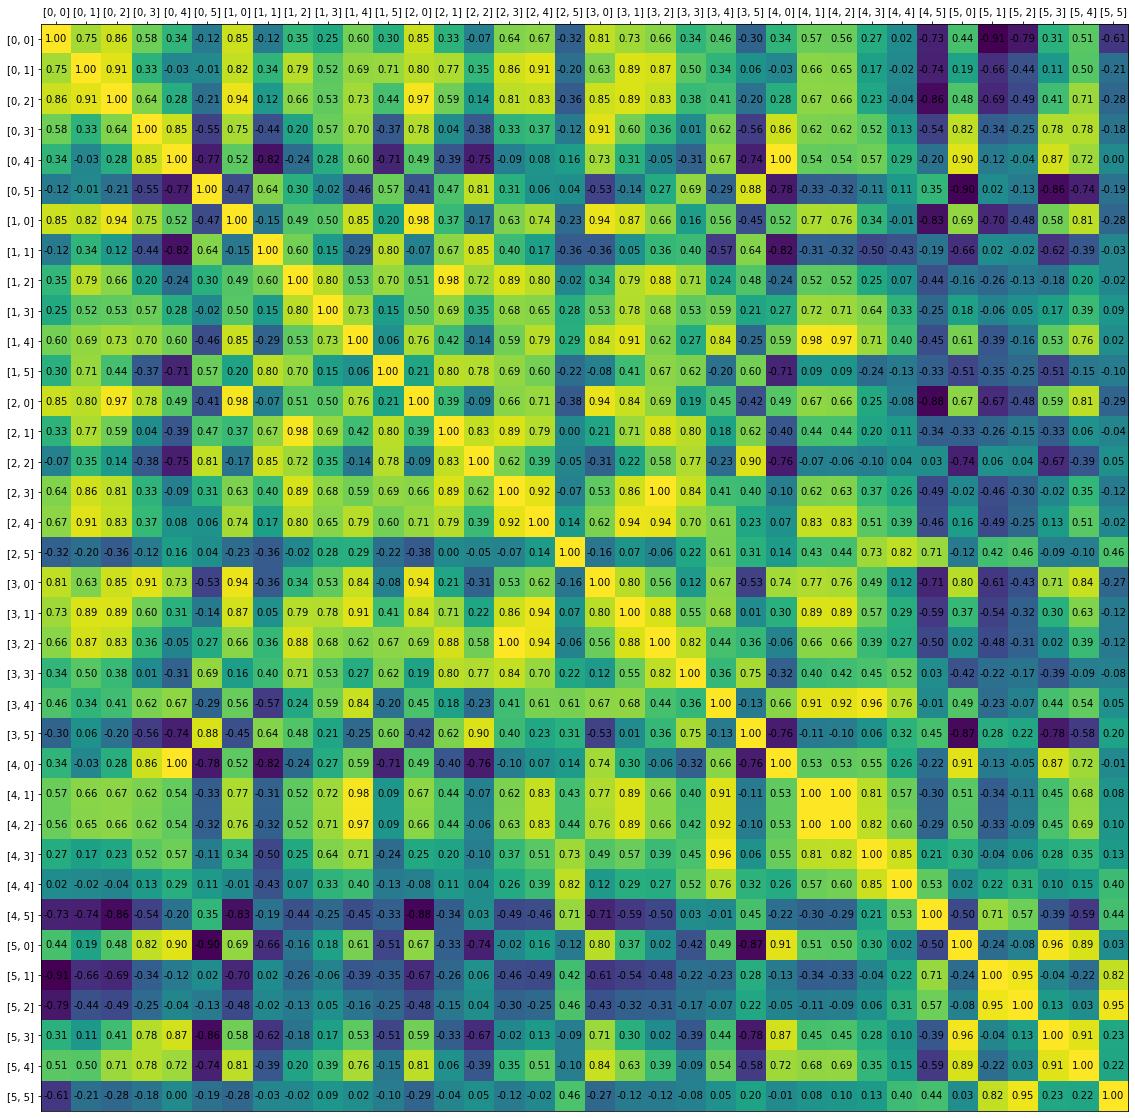

In [247]:
prompts = torch.cartesian_prod(torch.arange(6), torch.arange(6))
output = model(prompts, history='self_attn_non_residual')
output = output[:, -1, :]
cosine_similarity = torch.cosine_similarity(output[None,:,:], output[:,None,:], dim=-1)
# plot cosine similarity matrix
plt.figure(figsize=(20, 20))
plt.imshow(cosine_similarity.detach().numpy(), cmap='viridis')
# put x labels on top
plt.gca().xaxis.tick_top()
plt.xticks(range(cosine_similarity.shape[0]), prompts.tolist())
plt.yticks(range(cosine_similarity.shape[0]), prompts.tolist())

for i in range(cosine_similarity.shape[0]):
    for j in range(cosine_similarity.shape[1]):
        plt.text(j, i, f'{cosine_similarity[i,j]:.2f}', ha='center', va='center')


In [14]:
ps = [2, 3]
print('early stopping: ', model.unembed(model(prompts[ps], history='norm1'))[:,-1,:].argmax(-1).squeeze(-1).tolist())
print('final output  : ', model(prompts[ps])[:,-1,:].argmax(-1).squeeze(-1).tolist())


early stopping:  [6, 9]
final output  :  [8, 8]


So the prompts where the cosine similarity of the norm1 is very high, these are memories that are stored in the attention


In [7]:
def plot_when_first_token_equals(i, ax):
    prompts = torch.tensor([[j, i] for j in range(n_tokens)])
    out = model(prompts, history='norm1')[:, -1, :]
    ax.imshow(out.detach().numpy(), cmap='bwr', vmin=-2, vmax=2)
    ax.set_title(f'When first token equals {i}')
    for j in range(n_tokens):
        for k in range(model.d_model):
            ax.text(k, j, f'{out[j,k].item():.3f}', ha='center', va='center')

In [8]:
def plot_when_second_token_equals(j, ax):
    prompts = torch.tensor([[j, i] for i in range(n_tokens)])
    out = model(prompts, history='norm1')[:, -1, :]
    ax.imshow(out.detach().numpy(), cmap='bwr', vmin=-2, vmax=2)
    ax.set_title(f'When second token equals {j}')
    for j in range(n_tokens):
        for k in range(model.d_model):
            ax.text(k, j, f'{out[j,k].item():.3f}', ha='center', va='center')

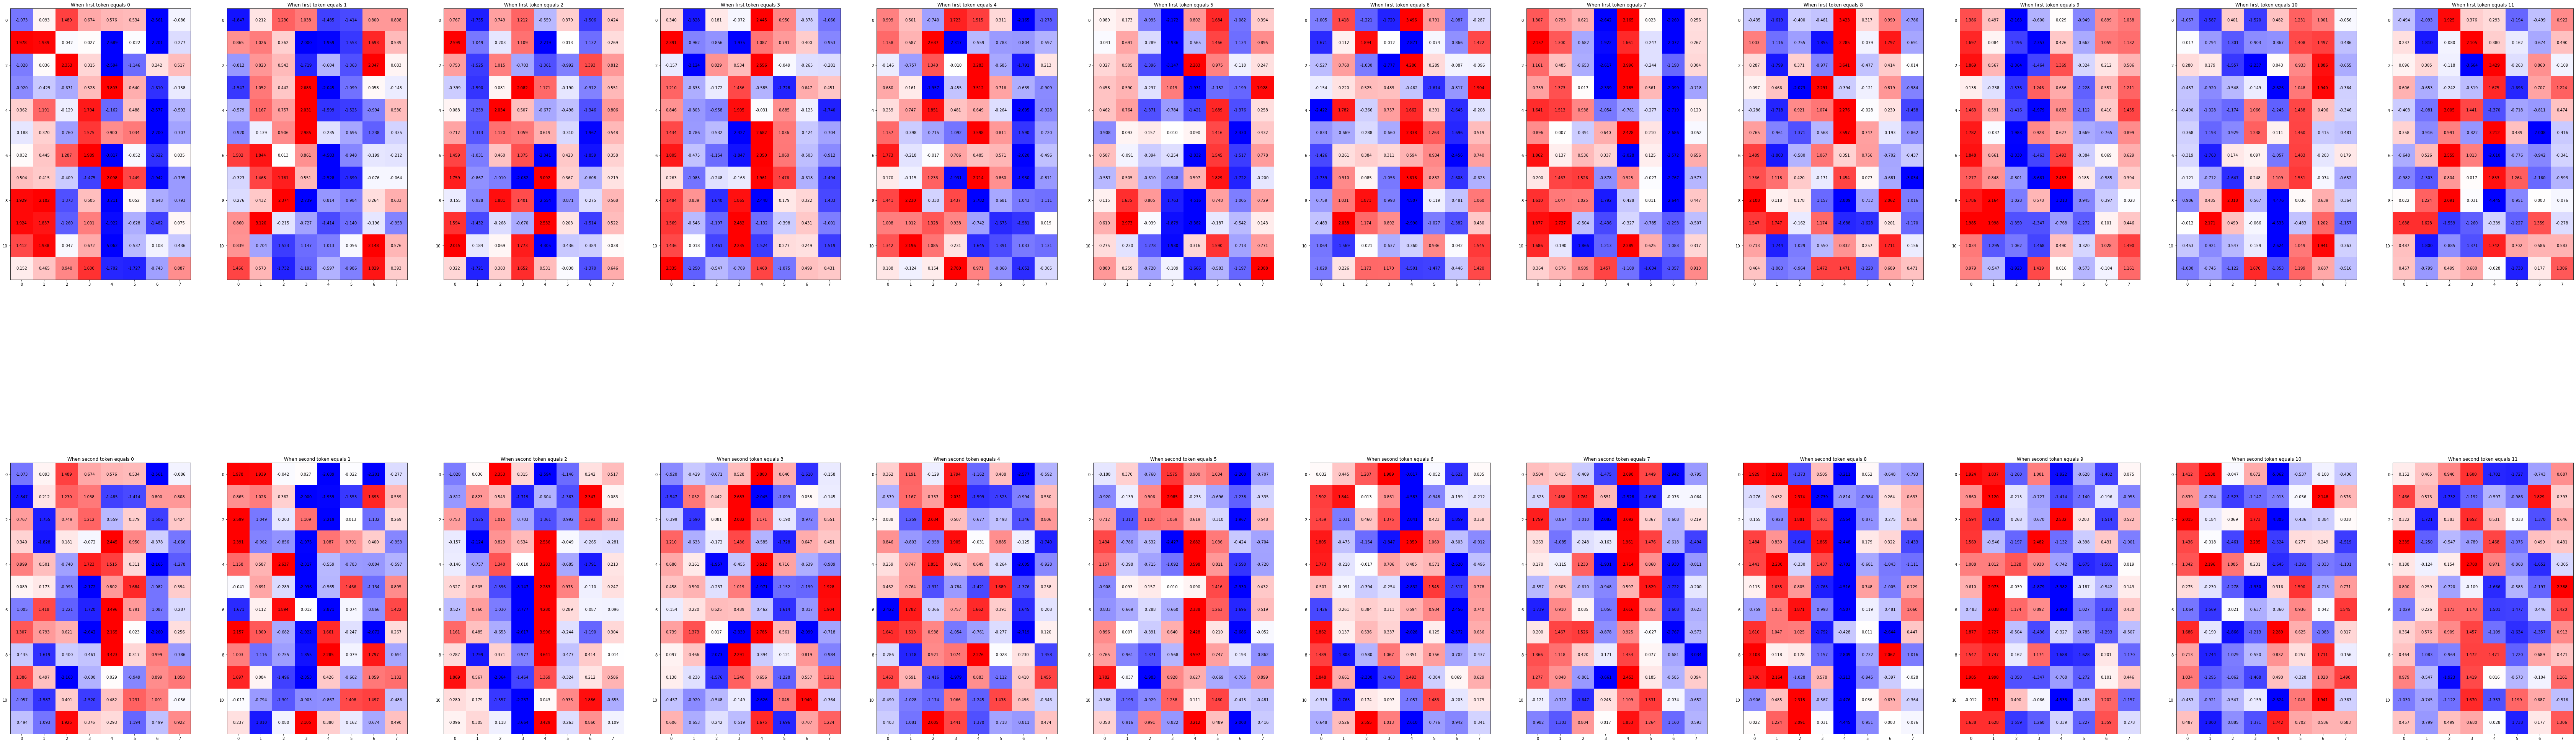

In [9]:
fig, axs = plt.subplots(2, n_tokens, figsize=(120, 40))
for i in range(n_tokens):
    plot_when_first_token_equals(i, axs[0, i])

for i in range(n_tokens):
    plot_when_second_token_equals(i, axs[1, i])
    

In [248]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size, bias=False)
        self.linear2 = nn.Linear(hidden_size, input_size, bias=False)
        

    def forward(self, x):
        x # [batch_size, input_size]
        h = self.linear1(x) # [batch_size, hidden_size]
        x = self.linear2(h) # [batch_size, input_size]
        return x, h

    def train(self, lr, epochs, print_every=1000, alpha=1, batch_size=100):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        total_loss1 = 0
        total_loss2 = 0
        for epoch in range(epochs):
            batch = model.generate_data(batch_size)[:,:2]
            norms = model(batch, history='norm1')[:,-1,:]

            optimizer.zero_grad()
            output, h = self(norms)
            
            loss1 = criterion(output, norms)
            loss2 = alpha * torch.nn.functional.cross_entropy(h[:,:n_tokens], batch[:,0]) \
            + alpha * torch.nn.functional.cross_entropy(h[:,n_tokens:], batch[:,1])
            # loss2 = torch.nn.functional.l1_loss(h, torch.zeros_like(h))
            # loss2 = alpha * h.norm(dim=1, p=1).mean()
            loss = loss1 + loss2

            total_loss1 += loss1.item()
            total_loss2 += loss2.item()

            loss.backward()
            optimizer.step()
            if epoch % print_every == 0 and epoch > 0:
                print(f"Epoch: {epoch}, loss: {total_loss1/print_every:.6f} {total_loss2/print_every:.6f}")
                total_loss1 = 0
                total_loss2 = 0


In [71]:
autoenc = AutoEncoder(model.d_model, 24)
autoenc.train(lr=1e-2, epochs=10000, batch_size=288, alpha=3)

Epoch: 1000, loss: 0.019673 7.299539
Epoch: 2000, loss: 0.000688 6.429012
Epoch: 3000, loss: 0.000875 6.254989
Epoch: 4000, loss: 0.001103 6.139026
Epoch: 5000, loss: 0.001016 6.063495
Epoch: 6000, loss: 0.001285 6.015398
Epoch: 7000, loss: 0.001364 5.982998
Epoch: 8000, loss: 0.001329 5.942415
Epoch: 9000, loss: 0.001265 5.920620


In [63]:
import numpy as np
torch.set_printoptions(precision=2, sci_mode=False, linewidth=600, edgeitems=24)

batch = torch.cartesian_prod(torch.arange(12), torch.arange(12),)
inp = model(batch, history='norm1')[:,-1,:]
output, h = autoenc(inp)

# remove columns with all zeros
h = h[:, (h.abs() > 0.01).any(dim=0)]

h = h.detach().numpy()
print(h.mean(axis=0))
# h = h - h.mean(axis=0)
# plot h
plt.figure(figsize=(10,80))
plt.yticks(np.arange(0, len(batch)), batch.detach().tolist())
plt.xticks(np.arange(0, len(h[0])), np.arange(0, len(h[0])))
# put x axis on top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
for i, j in zip(*np.where(h != 0)):
    plt.text(j, i, '{:.2f}'.format(h[i, j]), ha='center', va='center', color='black')
plt.imshow(h, cmap='bwr')


[ 0.36842847  0.29289776 -0.67820275 -0.4209507   0.59223205 -0.27419558
  0.2787874  -0.40702704 -0.20435148 -0.00618671  0.05826455 -0.5297326
  1.7512565  -1.7326324   1.1446571  -0.6191747   1.0280688  -0.492048
 -2.0960531   1.6260436  -1.9994646   0.19134028 -4.1334033   1.8301773 ]


Error in callback <function flush_figures at 0x7fc16ea3ff40> (for post_execute):


KeyboardInterrupt: 

In [72]:
torch.set_printoptions(precision=3, sci_mode=False, linewidth=600)
batch = torch.cartesian_prod(torch.arange(12), torch.arange(12),)
inp = model(batch, history='norm1')[:,-1,:]
output, h = autoenc(inp)
for i in range(h.shape[0]):
    print(f'{repr(batch[i].tolist()):<10}', end='')
    h1, h2 = h[i].chunk(2)
    h1 = h1.softmax(0)
    h2 = h2.softmax(0)
    print(f'{h1.argmax().item():<2}, {h2.argmax().item():<2}', end=' | ')
    for k in range(h1.shape[0]):
        print(f'{h1[k]:.3f} ', end='')
    print('| ', end='')
    for k in range(h2.shape[0]):
        print(f'{h2[k]:.3f} ', end='')
    print() 

[0, 0]    4 , 0  | 0.181 0.003 0.008 0.015 0.328 0.194 0.062 0.196 0.004 0.005 0.001 0.004 | 0.955 0.000 0.000 0.000 0.000 0.003 0.031 0.010 0.000 0.000 0.000 0.000 
[0, 1]    3 , 1  | 0.132 0.003 0.197 0.392 0.040 0.003 0.002 0.006 0.005 0.023 0.005 0.194 | 0.000 0.730 0.000 0.000 0.000 0.000 0.270 0.000 0.000 0.000 0.000 0.000 
[0, 2]    6 , 2  | 0.026 0.087 0.001 0.005 0.084 0.130 0.473 0.003 0.031 0.002 0.102 0.055 | 0.000 0.000 0.986 0.004 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.009 
[0, 3]    5 , 3  | 0.190 0.037 0.056 0.019 0.095 0.248 0.066 0.246 0.008 0.004 0.022 0.009 | 0.000 0.000 0.000 0.653 0.000 0.000 0.000 0.000 0.344 0.000 0.000 0.002 
[0, 4]    5 , 4  | 0.041 0.002 0.001 0.053 0.296 0.439 0.053 0.056 0.003 0.040 0.003 0.013 | 0.000 0.000 0.000 0.039 0.956 0.000 0.000 0.000 0.002 0.000 0.000 0.002 
[0, 5]    7 , 5  | 0.128 0.125 0.029 0.010 0.084 0.111 0.151 0.238 0.028 0.013 0.082 0.002 | 0.000 0.000 0.000 0.000 0.000 0.972 0.028 0.000 0.000 0.000 0.000 0.000 
[0, 

In [470]:
class InformationRetreival(nn.Module):
    def __init__(self, input_size, n_tokens, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.linear1 = nn.Linear(input_size, n_tokens)
        self.linear2 = nn.Linear(input_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, n_tokens)

    def forward(self, x):
        second_tokens = self.linear1(x)
        x = x #- model.embed(second_tokens.argmax(dim=1))
        x = self.linear2(x)
        h = torch.relu(x)
        first_tokens = self.linear3(h)
        return first_tokens, second_tokens, h
        
    @property
    def device(self):
        return next(self.parameters()).device

    def train(self, lr, epochs, print_every=1000, alpha=1, beta=1, batch_size=100):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        total_loss1 = 0
        total_loss2 = 0
        for epoch in range(epochs):
            batch = model.generate_data(batch_size)[:,:2]
            norms = model(batch, history='self_attn')[:,-1,:]

            optimizer.zero_grad()
            first_tokens, second_tokens, h = self(norms)
            loss1 = torch.nn.functional.cross_entropy(first_tokens, batch[:,0]) \
            + torch.nn.functional.cross_entropy(second_tokens, batch[:,1])
            loss2 = alpha * h.norm(dim=1, p=0.5).mean()

            total_loss1 += loss1.item()
            total_loss2 += loss2.item()

            loss = loss1 + loss2

            loss.backward()
            optimizer.step()
            if epoch % print_every == 0 and epoch > 0:
                print(f"Epoch: {epoch}, loss: {total_loss1/print_every:.6f} {total_loss2/(alpha * print_every):.6f}")
                total_loss1 = 0
                total_loss2 = 0

In [471]:
ir = InformationRetreival(model.d_model, n_tokens, hidden_size=40).to(device)
ir.train(lr=4e-2, epochs=40000, alpha=0.03, batch_size=2*12**2)

Epoch: 1000, loss: 1.209294 7.656373
Epoch: 2000, loss: 0.736424 5.959146
Epoch: 3000, loss: 0.660383 5.563234
Epoch: 4000, loss: 0.626736 5.083107
Epoch: 5000, loss: 0.689236 5.033644
Epoch: 6000, loss: 0.660444 5.064928
Epoch: 7000, loss: 0.672642 5.124239
Epoch: 8000, loss: 0.645988 5.268677


KeyboardInterrupt: 

In [472]:
torch.set_printoptions(precision=3, sci_mode=False, linewidth=600)
batch = torch.cartesian_prod(torch.arange(12), torch.arange(12),)
inp = model(batch, history='self_attn')[:,-1,:]
first_tokens, second_tokens, h = ir(inp)
# remove all-zero columns from h
h = h[:, (h.abs() > 0.1).any(dim=0)]
print(h.shape)
for i in range(first_tokens.shape[0]):
    print(f'{memory[batch[i][0],batch[i][1]]:<4} {repr(batch[i].tolist()):<10}', end='')
    print(f'{first_tokens[i].argmax().item():<2}, {second_tokens[i].argmax().item():<2}', end=' | ')
    nonzero = h[i].nonzero().flatten()
    if len(nonzero) == 0:
        print()
        continue
    nz0 = nonzero.tolist()
    nz1 = h[i][nonzero].tolist()
    # sort nz0 by nz1
    nz0, nz1 = zip(*sorted(zip(nz0, nz1), key=lambda x: x[1], reverse=True))
    print(nz0, nz1)
    print()

torch.Size([144, 11])
8    [0, 0]    0 , 0  | (3, 10) (1.432805061340332, 0.4291611313819885)

1    [0, 1]    0 , 1  | (6, 4, 10) (1.0738890171051025, 0.2583386301994324, 0.2237125039100647)

4    [0, 2]    0 , 2  | (3,) (0.440014123916626,)

5    [0, 3]    0 , 3  | (3,) (0.46428394317626953,)

5    [0, 4]    0 , 4  | (3,) (0.2827848196029663,)

11   [0, 5]    0 , 5  | (3, 10) (0.513364315032959, 0.37403184175491333)

1    [0, 6]    9 , 6  | 
4    [0, 7]    0 , 7  | (0, 1, 4) (3.9828271865844727, 1.7624841928482056, 1.0965616703033447)

11   [0, 8]    0 , 8  | (3, 2) (0.6644620895385742, 0.313418984413147)

7    [0, 9]    0 , 9  | (3,) (0.28560078144073486,)

6    [0, 10]   0 , 10 | (4,) (0.1110982894897461,)

3    [0, 11]   0 , 11 | (6, 3, 8) (2.7574303150177, 1.654087781906128, 1.0671327114105225)

6    [1, 0]    1 , 0  | (3, 2) (1.0819580554962158, 0.6256941556930542)

2    [1, 1]    1 , 1  | (1, 6) (1.2049707174301147, 0.5297262668609619)

2    [1, 2]    1 , 2  | (2, 4, 3) (1.69195

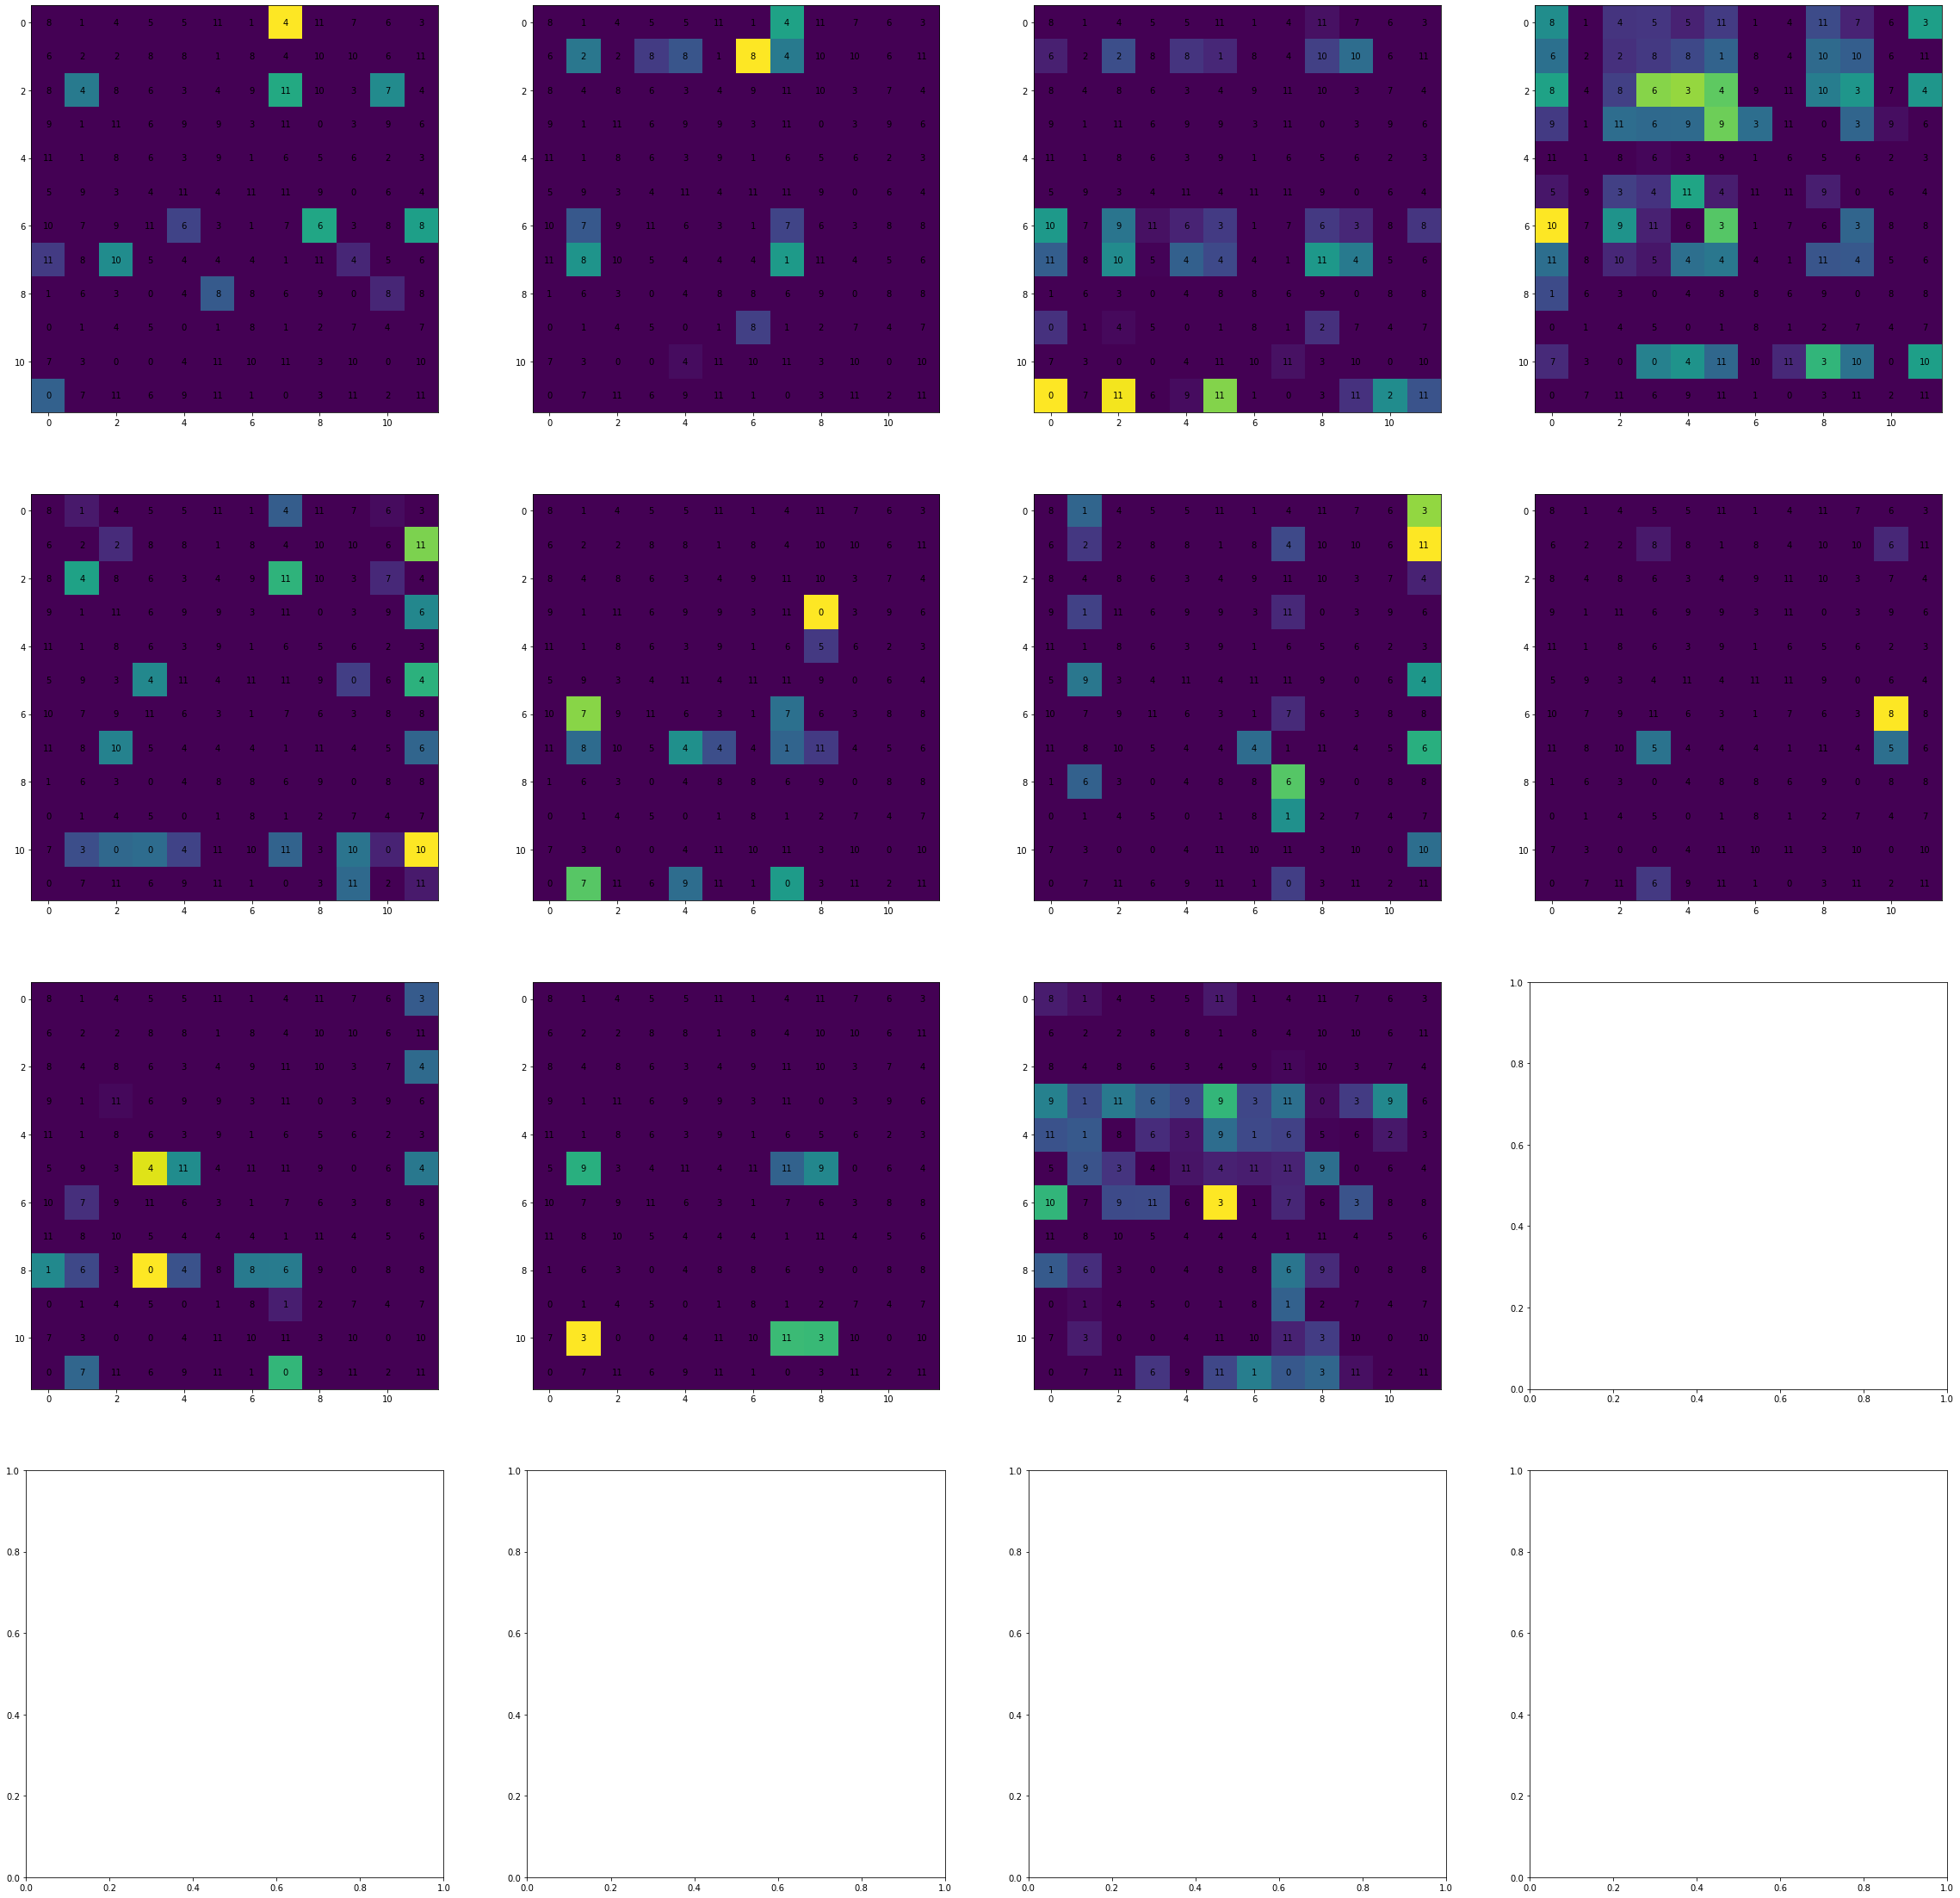

In [473]:
fig, axs = plt.subplots(4, 4, figsize=(40, 40))
for i in range(h.shape[1]):
    axs[i // 4, i % 4].imshow(h[:,i].reshape(n_tokens,n_tokens).detach().numpy(), cmap='viridis')
    for j in range(n_tokens):
        for k in range(n_tokens):
            axs[i // 4, i % 4].text(k, j, str(memory[j, k].item()), ha='center', va='center', color='black')

In [33]:
memory[2, 2], memory[11, 11]

(tensor(10), tensor(0))

In [37]:
autoenc.encoder[0].weight.shape

torch.Size([24, 8])

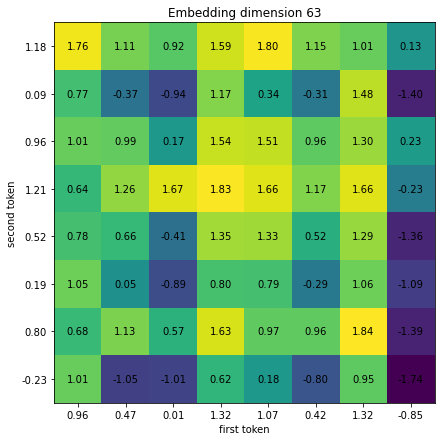

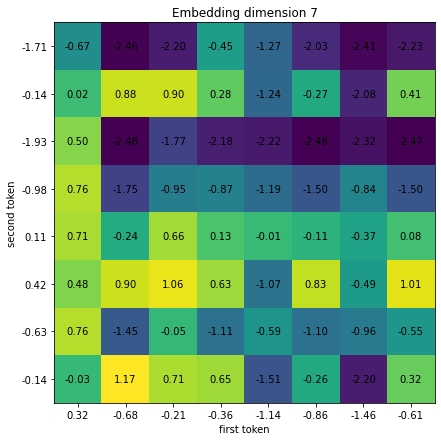

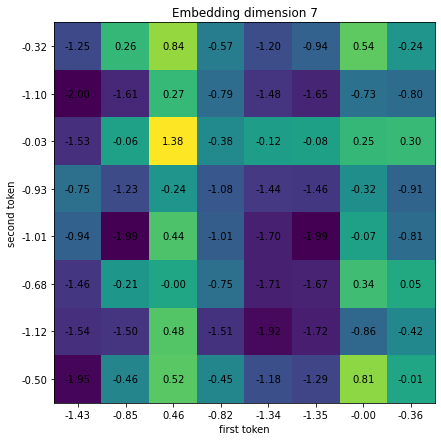

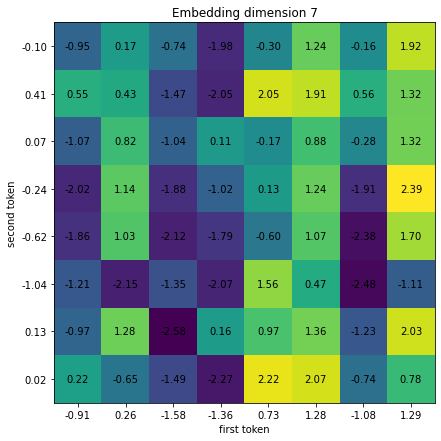

In [29]:
for k in range(model.d_model):
    prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
    x = model(prompts, history='norm1')
    x = x[:,-1,:]
    x = x.reshape(n_tokens, n_tokens, model.d_model)[:, :, k]
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(x.detach().numpy(), cmap='viridis')
    # set x axis
    plt.xticks(range(n_tokens), [f'{avg:.2f}' for avg in x.mean(dim=0).detach().numpy()])
    plt.xlabel('first token')
    # set y axis
    plt.yticks(range(n_tokens), [f'{avg:.2f}' for avg in x.mean(dim=1).detach().numpy()])
    plt.ylabel('second token')
    # set title
    plt.title(f'Embedding dimension {i}')

    for i in range(n_tokens):
        for j in range(n_tokens):
            text = ax.text(j, i, f'{x[i, j].item():.2f}',
                           ha="center", va="center")



In [127]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
n_prompts = prompts.shape[0]
x = model(prompts, history='norm1')
x = x[:,-1,:]
x = x / x.norm(dim=-1, keepdim=True)
similarity_matrix = torch.matmul(x, x.T)
similarity_matrix = similarity_matrix.detach().numpy()
fig, ax = plt.subplots(figsize=(50, 50))
im = ax.imshow(similarity_matrix, cmap='viridis')
ax.xaxis.tick_top()
plt.xticks(range(n_prompts), range(n_prompts))
plt.yticks(range(n_prompts), range(n_prompts))
for i in range(n_prompts):
    for j in range(n_prompts):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center")

Error in callback <function flush_figures at 0x7ff29d0bfa30> (for post_execute):


KeyboardInterrupt: 

In [ ]:
prompts[[1, 2],:]

tensor([[2, 4],
        [1, 7]])

In [ ]:
model(torch.tensor([[1, 7]])).argmax(dim=-1)

tensor([[9, 6]])

In [ ]:
memory[1,7]

tensor(6)

In [ ]:
x = prompts[[1, 2],:]
model(x, history='norm1')[:,-1,:]

tensor([[ 2.6027, -0.5499, -0.7317, -0.4105],
        [ 2.5530, -0.6079, -0.1669, -0.9021]], grad_fn=<SliceBackward0>)

In [ ]:
model(x, history='linear1')[:,-1,:]

tensor([[0.0000, 0.7982, 0.0000, 2.0212, 0.0000, 1.3315, 0.5594, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.5408, 1.9068, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4619, 0.0000, 0.0000, 0.1887, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3188, 2.2467, 0.0000]],
       grad_fn=<SliceBackward0>)

In [ ]:
model(x, history='linear2')[:,-1,:]

tensor([[ 2.5960, -0.9660, -0.2612, -1.1601],
        [ 2.9685, -0.2743,  2.2922, -4.9422]], grad_fn=<SliceBackward0>)

In [ ]:
model(x, history='linear2_non_residual')[:,-1,:]

tensor([[-0.0068, -0.4161,  0.4705, -0.7496],
        [ 0.4155,  0.3336,  2.4591, -4.0400]], grad_fn=<SliceBackward0>)

In [ ]:
model(x, history='norm2')[:,-1,:]

tensor([[ 4.7872e-01,  3.0846e-02,  5.0042e-01, -8.1601e-03],
        [ 5.9969e-01,  6.1048e-02,  2.7516e-01, -3.7967e-04]],
       grad_fn=<SliceBackward0>)

In [ ]:
model.unembed(model(x, history='norm2')[:,-1,:]).softmax(dim=-1).topk(5, dim=-1)

torch.return_types.topk(
values=tensor([[9.7145e-01, 2.0764e-02, 7.7864e-03, 3.2140e-09, 4.9044e-13],
        [9.7059e-01, 1.7453e-02, 1.1089e-02, 8.5846e-04, 1.3038e-05]],
       grad_fn=<TopkBackward0>),
indices=tensor([[6, 7, 4, 2, 9],
        [7, 2, 6, 4, 9]]))

In [ ]:
model(x)[:,-1,:].argmax(dim=-1)

tensor([9, 5])

/tmp/ipykernel_789690/3258366675.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7, 7))


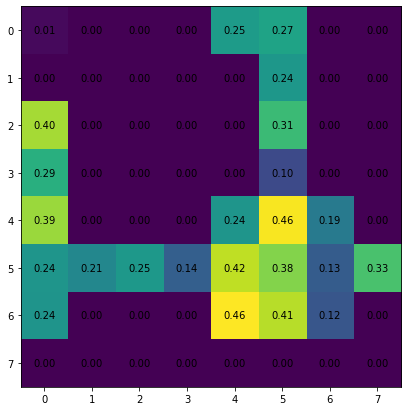

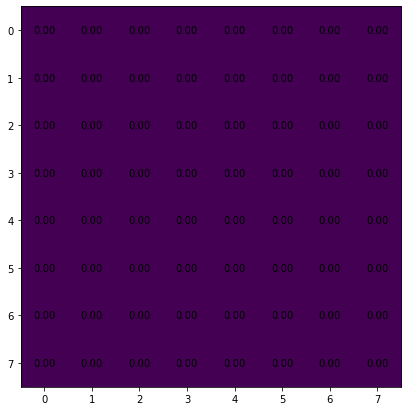

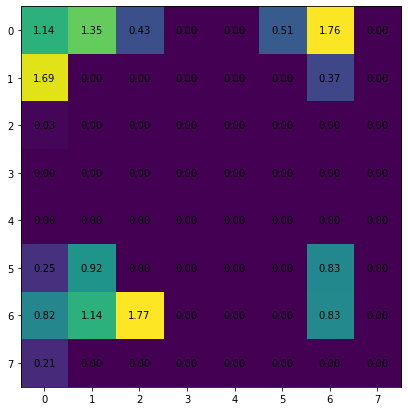

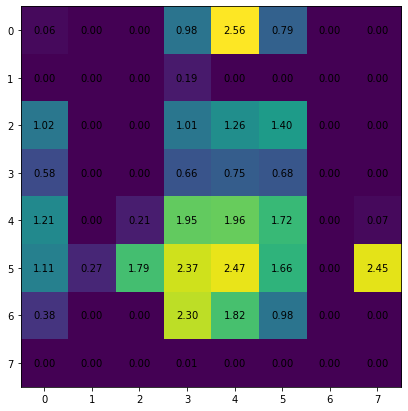

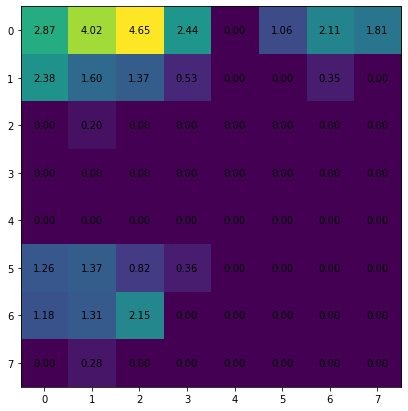

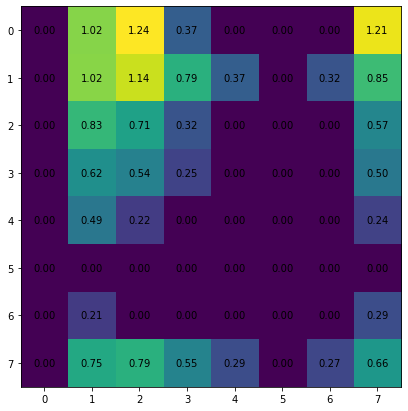

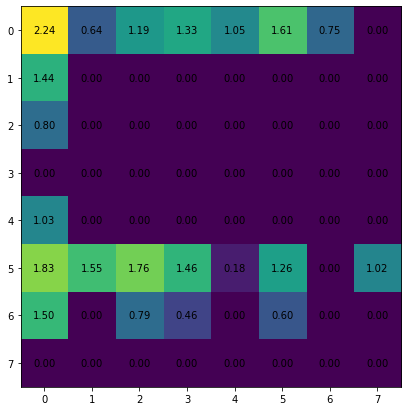

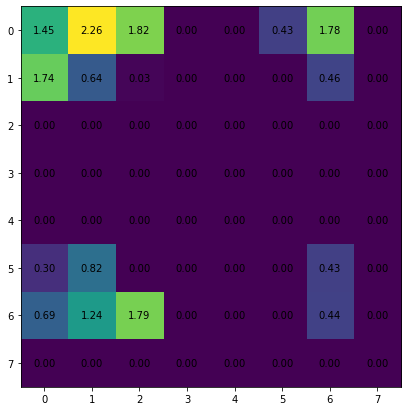

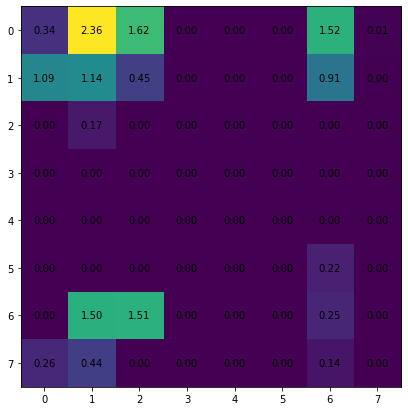

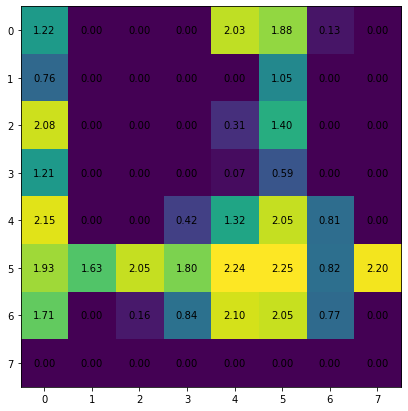

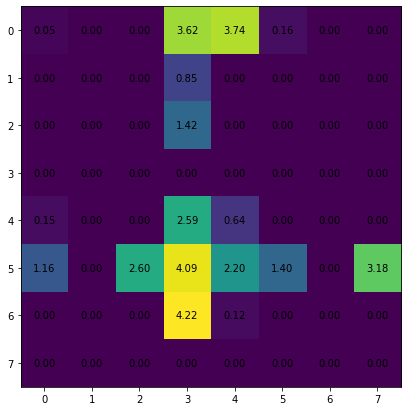

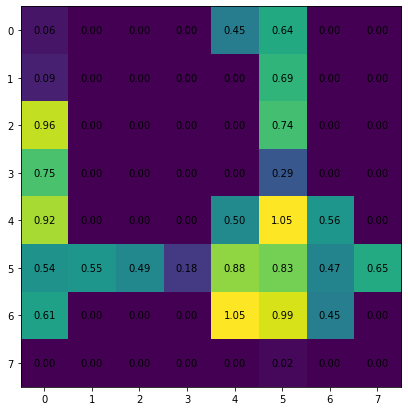

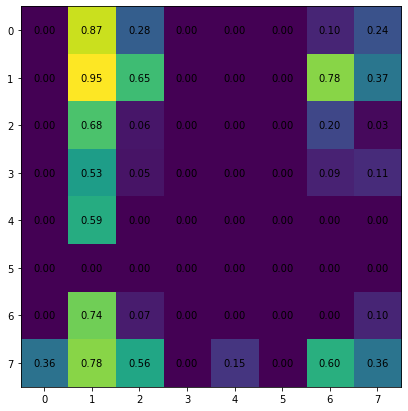

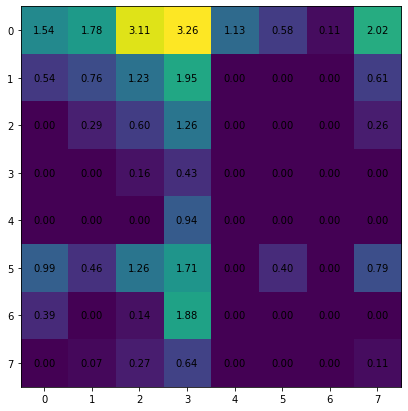

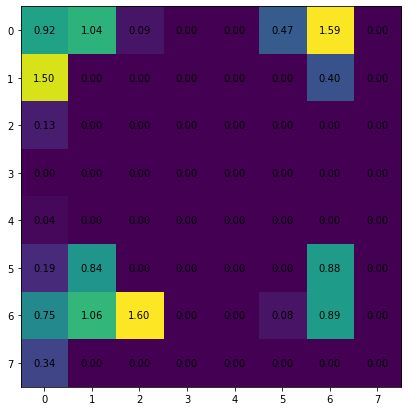

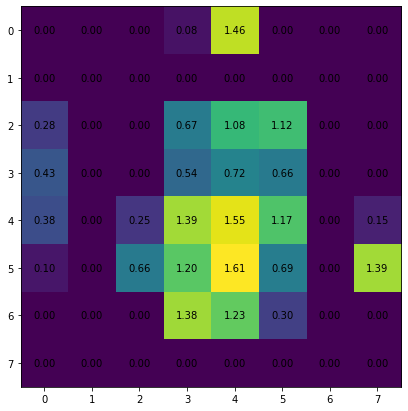

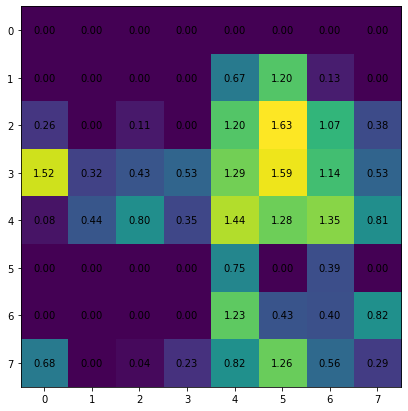

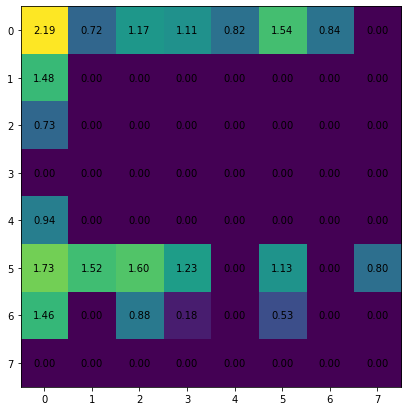

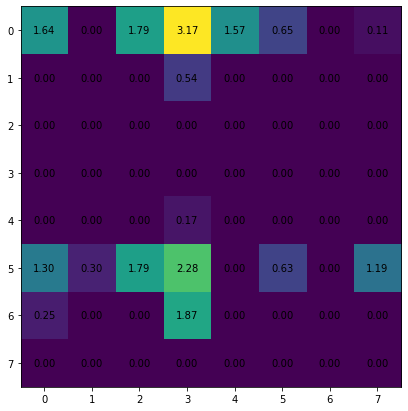

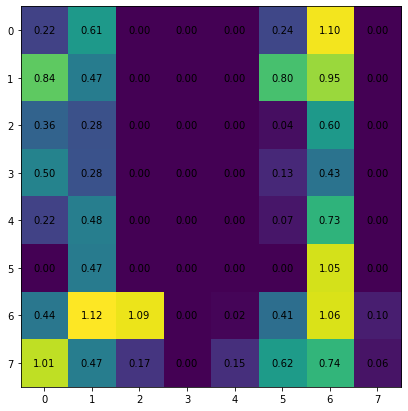

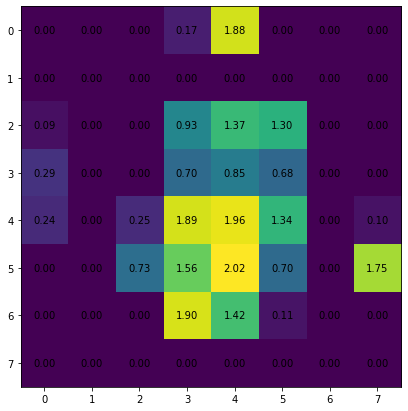

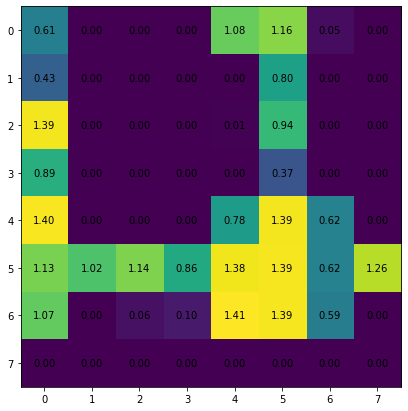

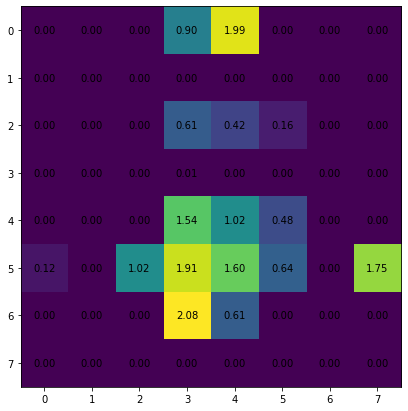

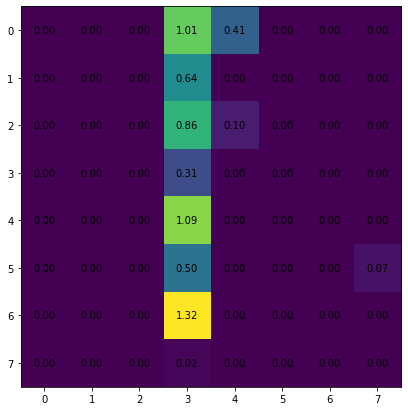

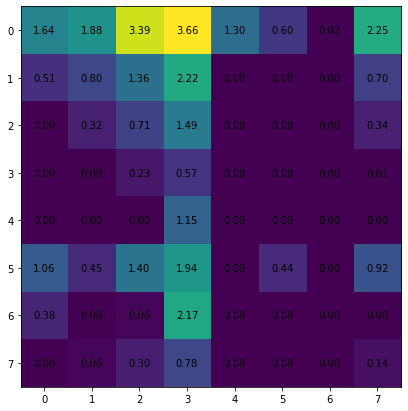

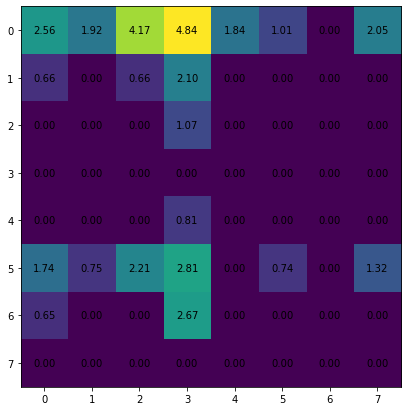

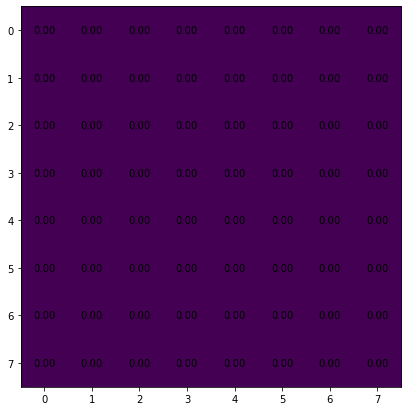

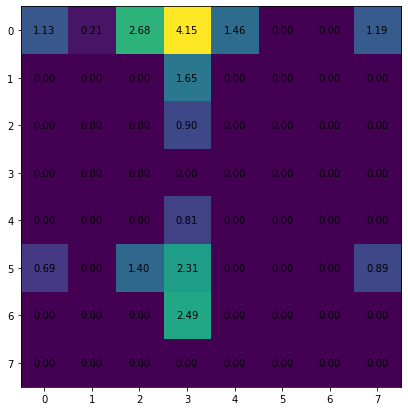

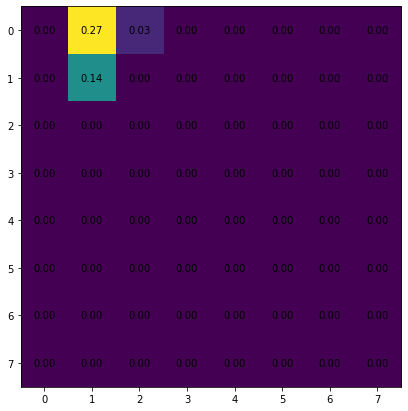

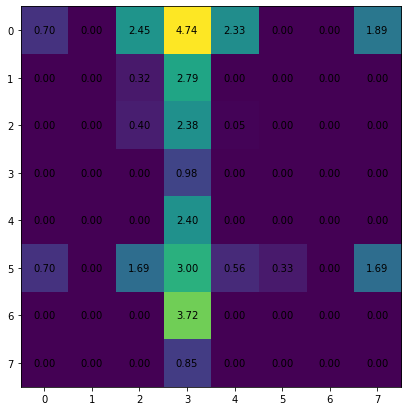

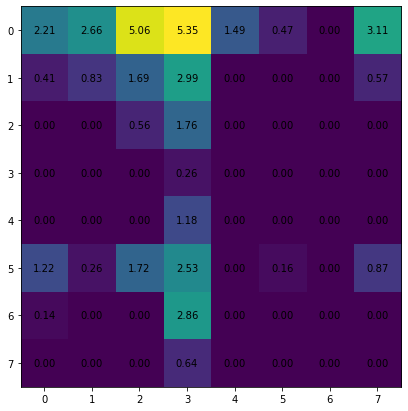

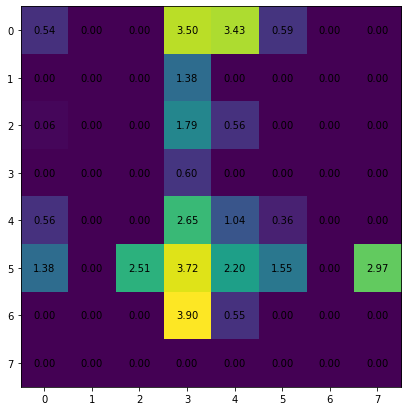

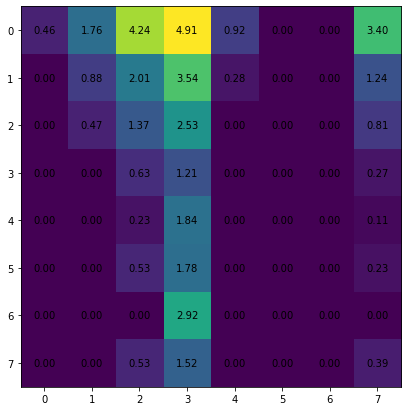

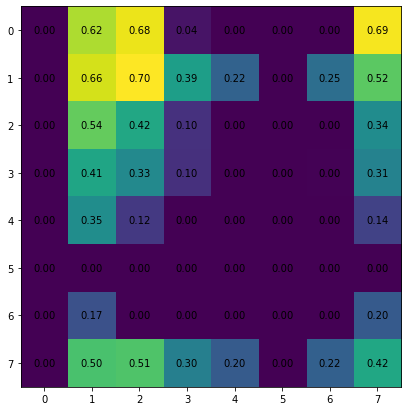

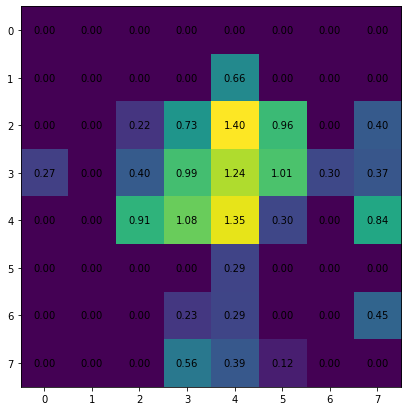

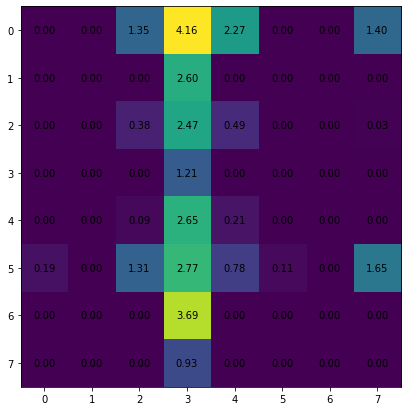

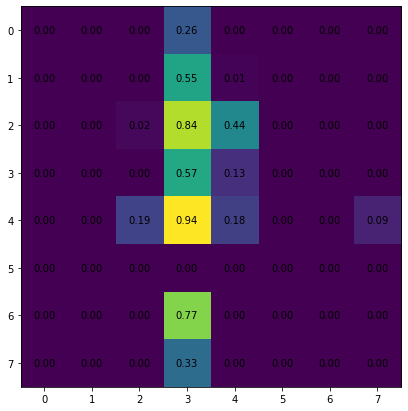

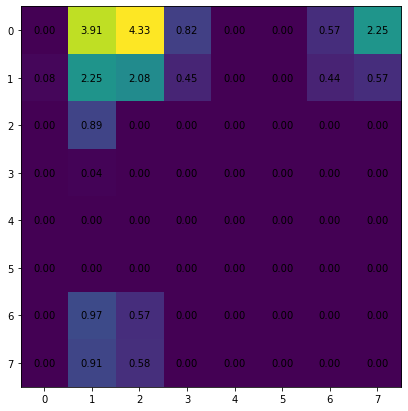

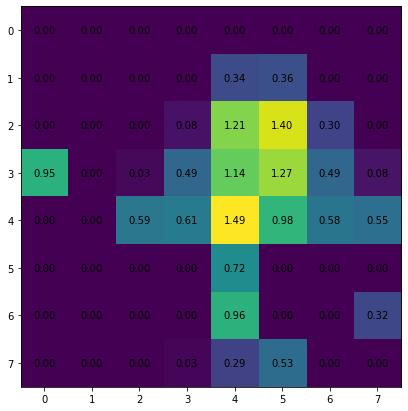

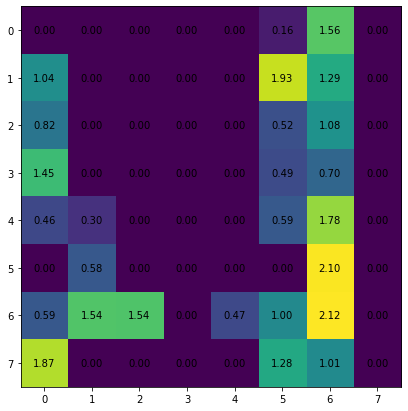

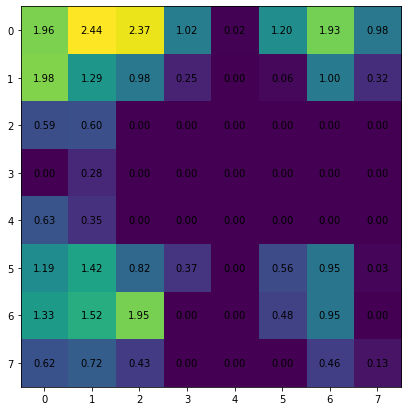

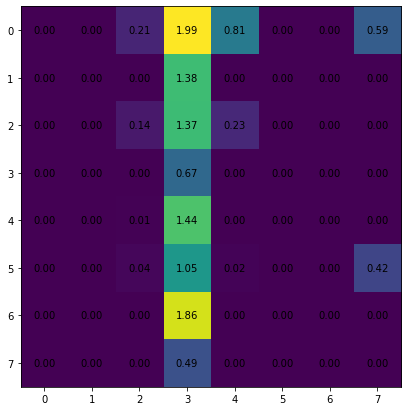

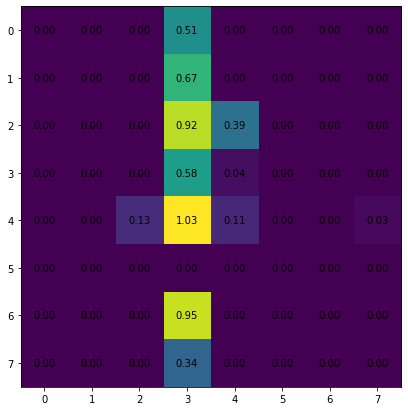

Error in callback <function flush_figures at 0x7ff29d0bfa30> (for post_execute):


KeyboardInterrupt: 

In [128]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
linear2 = model(prompts, history='linear1')[:,-1,:].view(n_tokens, n_tokens, model.hidden_size)
for dim in range(model.hidden_size):
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(linear2[:, :, dim].detach().numpy(), cmap='viridis')
    for i in range(n_tokens):
        for j in range(n_tokens):
            text = ax.text(j, i, f'{linear2[i, j, dim].item():.2f}',
                           ha="center", va="center")

In [129]:
U, S, Vh = torch.linalg.svd(model.layers[0].linear1.weight)
print(U.shape)
print(S.shape)
print(Vh.shape)
Smat = torch.cat((torch.diag(S), torch.zeros((U.shape[0] - S.shape[0], S.shape[0]))), dim=0)
torch.dist(model.layers[0].linear1.weight, U @ Smat @ Vh) # 0.0

torch.Size([64, 64])
torch.Size([4])
torch.Size([4, 4])


tensor(    0.000, grad_fn=<DistBackward0>)

In [118]:
torch.relu(U @ Smat)

tensor([[0.000, 0.333, 0.498, 0.000],
        [0.000, 0.169, 0.105, 0.119],
        [0.206, 0.175, 0.908, 0.298],
        [0.000, 1.098, 0.047, 0.000],
        [0.013, 0.153, 0.000, 0.000],
        [0.000, 0.000, 0.000, 0.083],
        [0.000, 0.341, 0.000, 0.000],
        [0.000, 0.007, 0.000, 0.000],
        [0.000, 1.099, 0.741, 0.543],
        [0.134, 0.000, 0.000, 0.136],
        [0.000, 0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000, 0.196],
        [0.171, 0.188, 0.770, 0.125],
        [0.000, 0.906, 0.000, 0.000],
        [0.000, 0.000, 0.000, 0.554],
        [0.000, 0.000, 0.353, 0.000],
        [0.134, 0.000, 0.000, 0.335],
        [0.000, 0.853, 0.225, 0.000],
        [0.385, 0.000, 0.556, 0.488],
        [0.000, 0.424, 0.808, 0.000],
        [0.014, 0.000, 0.000, 0.327],
        [0.000, 1.532, 0.105, 0.040],
        [0.000, 0.000, 0.000, 0.000],
        [0.000, 0.158, 1.021, 0.000],
        [0.654, 0.829, 0.097, 0.000],
        [0.0

In [84]:
U, S, Vh = torch.linalg.svd(model.layers[0].linear2.weight)

In [85]:
Smat = torch.cat((torch.diag(S), torch.zeros(Vh.shape[1] - S.shape[0], S.shape[0])), dim=-1)
torch.dist(model.layers[0].linear2.weight, U @ Smat @ Vh)

tensor(    0.000, grad_fn=<DistBackward0>)

In [71]:
prompts = torch.tensor([[0, 1], [0, 2]])
early = model.embed(prompts)[:,-1,:]
results = model(prompts, history='norm1')[:,-1,:]
results - early

tensor([[-0.078, -2.293,  0.581,  2.554,  0.766, -1.835, -2.582, -2.125],
        [ 0.833,  1.821,  2.653,  1.611, -0.017, -3.399, -0.441, -1.484]],
       grad_fn=<SubBackward0>)

In [43]:
torch.dist(model.layers[0].linear2.weight, U @ torch.diag_embed(S) @ Vh[:model.d_model, :])

tensor(    0.000, grad_fn=<DistBackward0>)

In [72]:
U1, S1, Vh1 = torch.svd(model.layers[0].linear1.weight)
print('U1 shape: ', U1.shape)

U1 shape:  torch.Size([16, 8])


In [73]:
S1mat = torch.diag(S1)

In [81]:
list(x[0] for x in model.layers[0].self_attn.named_parameters())

['in_proj_weight', 'in_proj_bias', 'out_proj.weight', 'out_proj.bias']

NameError: name 'Vh' is not defined

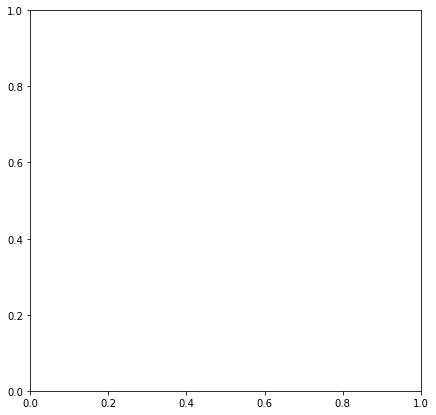

In [9]:
# plot Vh
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(Vh.detach().numpy(), cmap='viridis')
for i in range(model.layers[0].linear2.weight.shape[1]):
    for j in range(model.layers[0].linear2.weight.shape[1]):
        text = ax.text(j, i, f'{Vh[i, j].item():.2f}',
                       ha="center", va="center")

torch.Size([10, 10, 8])


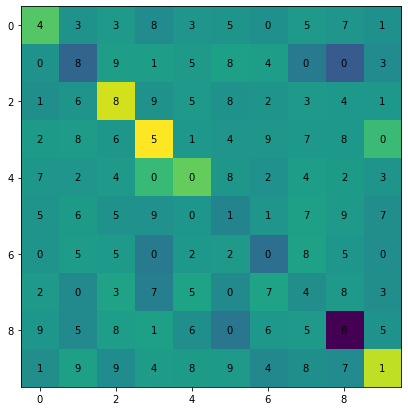

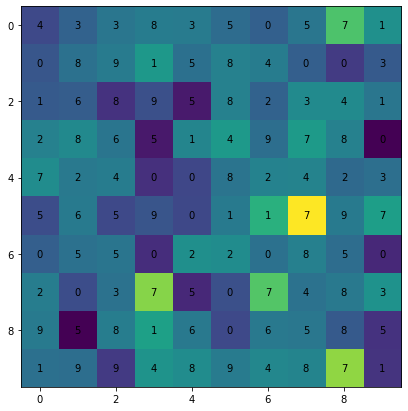

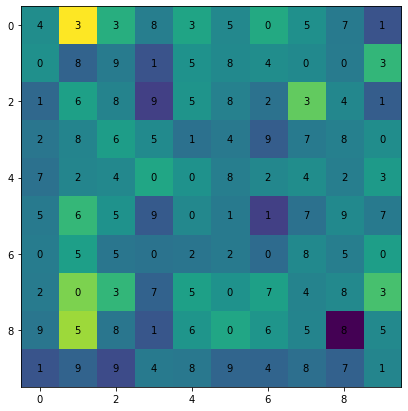

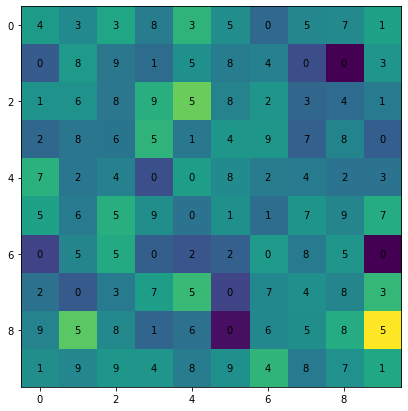

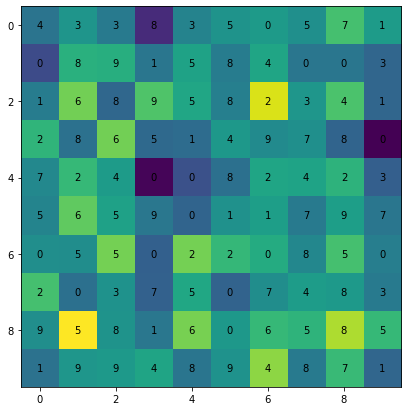

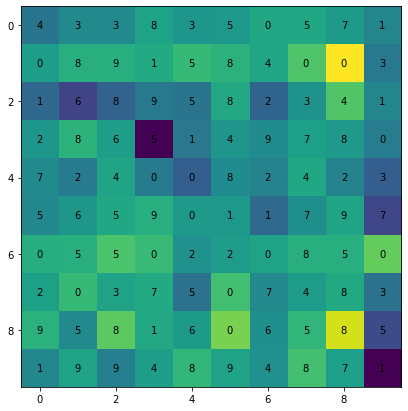

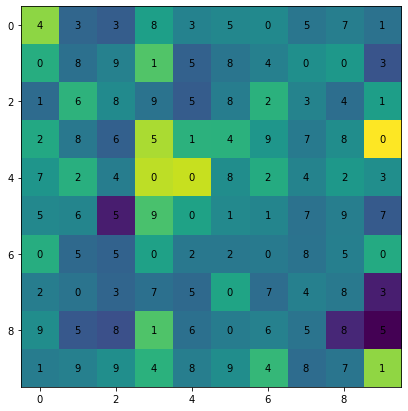

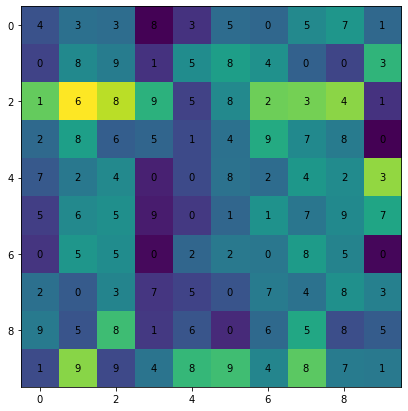

In [187]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
x = model(prompts, history='linear1')[:,-1,:].view(n_tokens, n_tokens, model.hidden_size)
results = model(prompts)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
x = x @ Vh.T[:,:8] @ torch.diag(S)
x = x.view(n_tokens, n_tokens, model.d_model)
print(x.shape)
for k in range(model.d_model):
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(x[:, :, k].detach().numpy(), cmap='viridis')
    for i in range(n_tokens):
        for j in range(n_tokens):
            text = ax.text(j, i, f'{results[i, j].item():}',
                           ha="center", va="center")

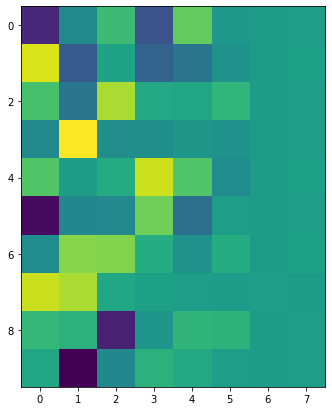

In [211]:
unembed = model.unembed.weight
U, S, Vh = torch.linalg.svd(unembed)
torch.dist(unembed, U @ torch.cat((torch.diag(S) @ Vh, torch.zeros(2, 8)), dim=0))
X = U @ (torch.cat((torch.diag(S), torch.zeros(2, 8)), dim=0))
# plot X
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X.detach().numpy(), cmap='viridis')

In [ ]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
x = model(prompts, history='linear2_non_residual')[:,-1,:].view(n_tokens, n_tokens, model.hidden_size)
results = model(prompts)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)


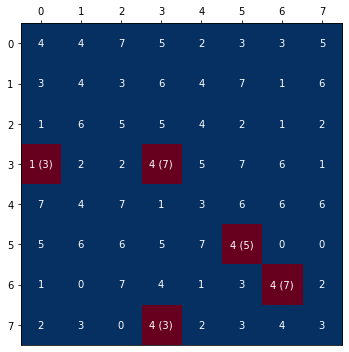

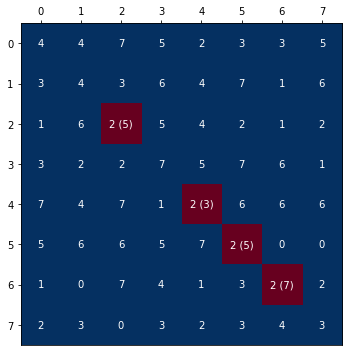

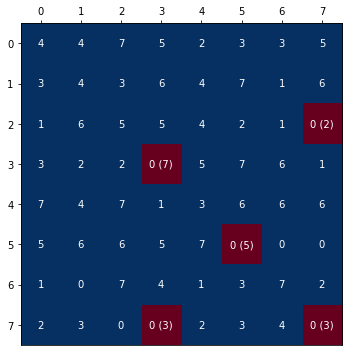

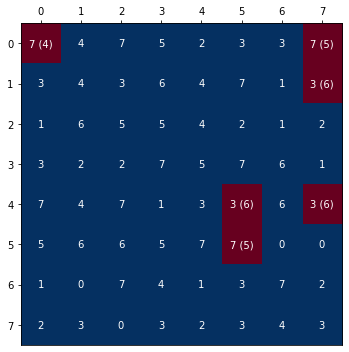

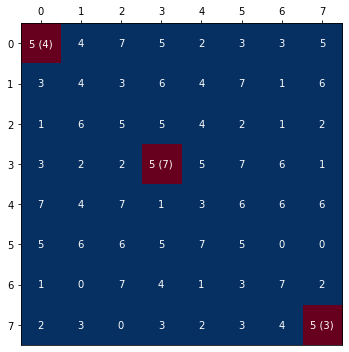

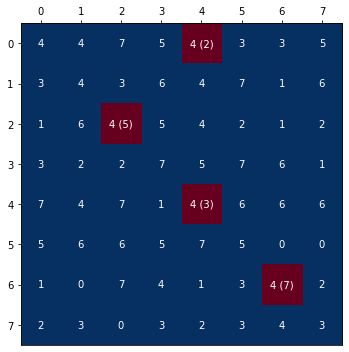

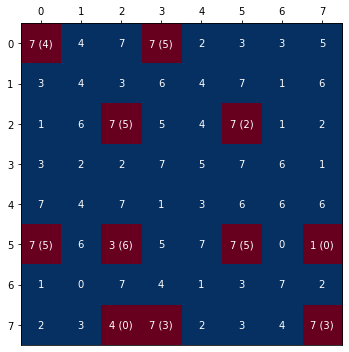

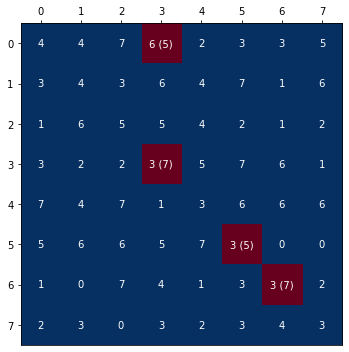

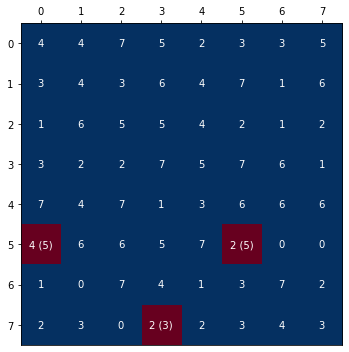

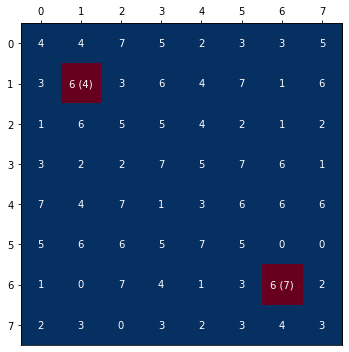

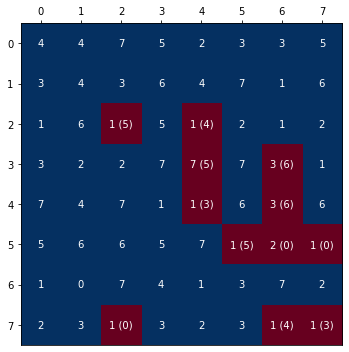

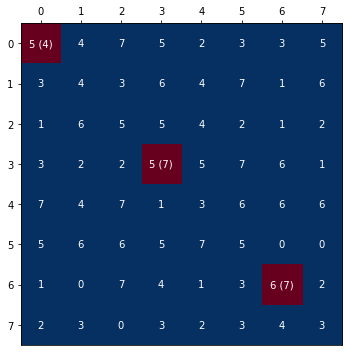

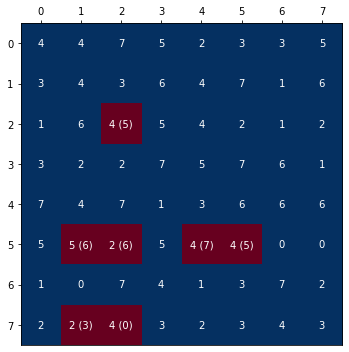

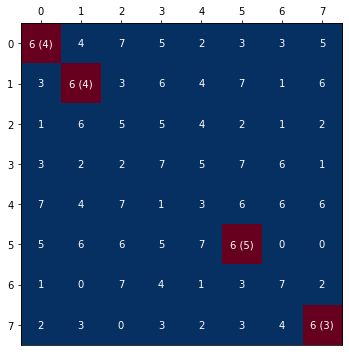

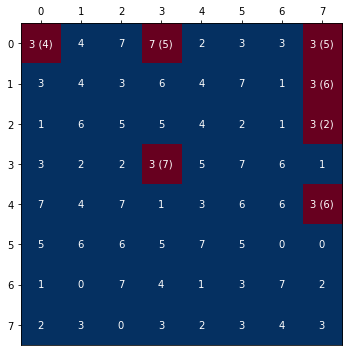

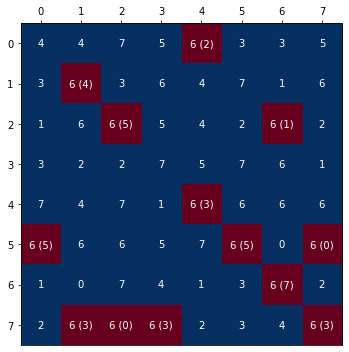

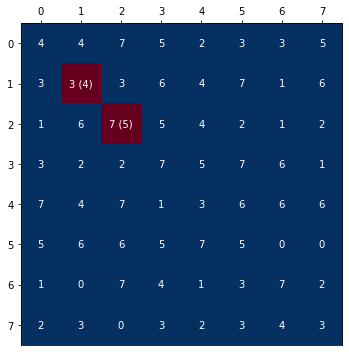

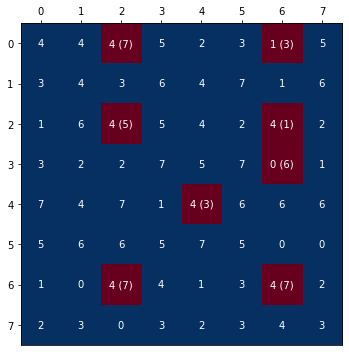

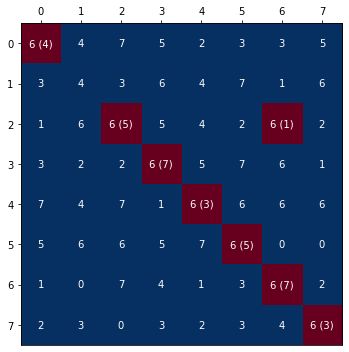

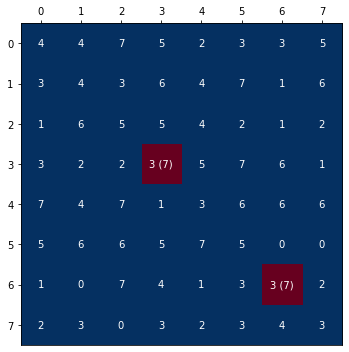

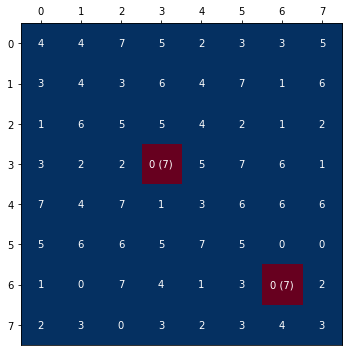

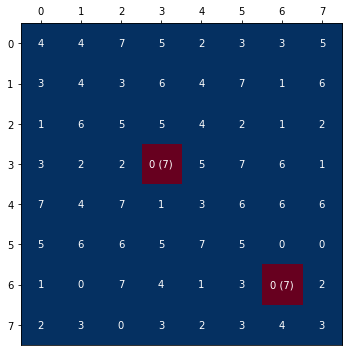

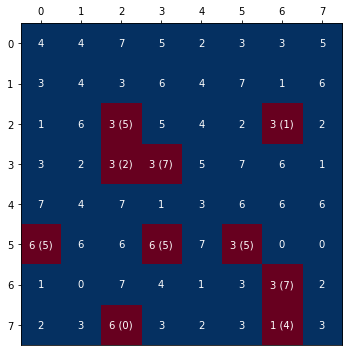

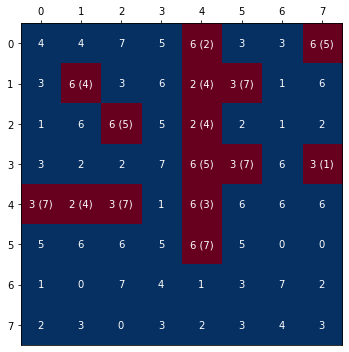

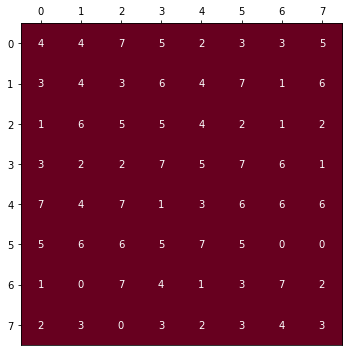

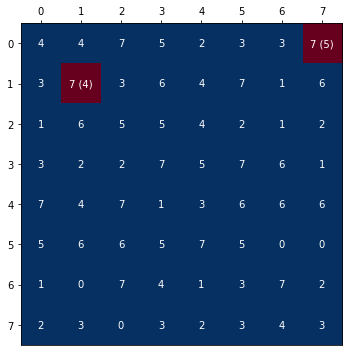

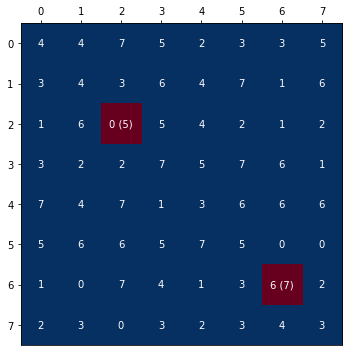

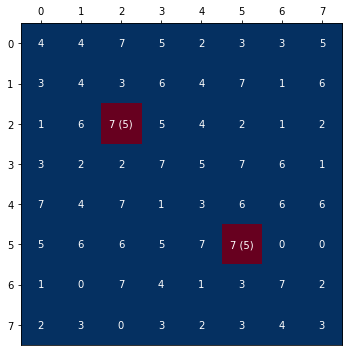

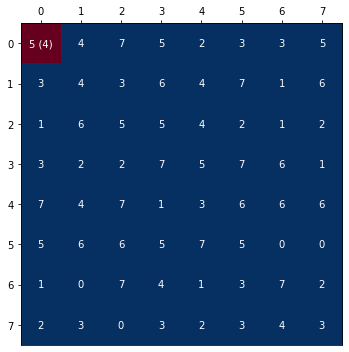

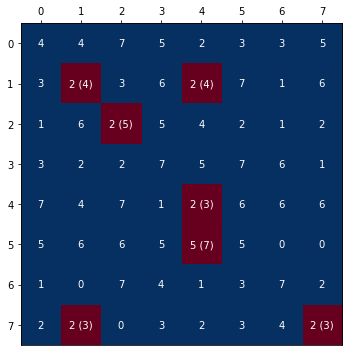

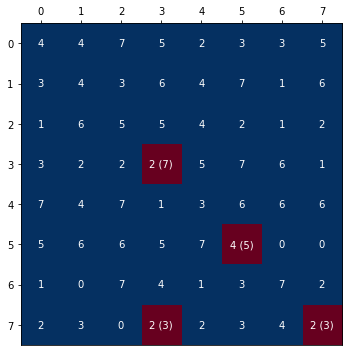

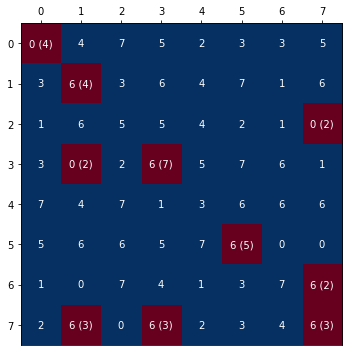

In [40]:
for dim in range(model.hidden_size):
    prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
    mask = torch.ones(model.hidden_size)
    mask[dim] = 0
    output = model(prompts, linear_mask=mask)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
    plot(output)